In [ ]:
# TODO: Add Open in Colab

## Setup environment

In [1]:
%cd /home/jdafflon/GenerativeModels

/mnt_homes/home4T7/jdafflon/GenerativeModels


In [2]:
import torch
import os
import torch
from pathlib import Path

from tqdm import tqdm
import matplotlib.pyplot as plt
from monai.apps import MedNISTDataset
from monai import transforms
from monai.data import DataLoader, Dataset
from monai.networks.layers import Act


from monai.config import print_config
from monai.utils import set_determinism

from generative.metrics import FID, MMD, MSSSIM
from generative.networks.nets import DiffusionModelUNet, PatchDiscriminator, AutoencoderKL
from generative.networks.schedulers import DDPMScheduler
from generative.inferers import DiffusionInferer

print_config()

/home/jdafflon/miniconda3/envs/genmodels/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.2.dev2304
Numpy version: 1.23.4
Pytorch version: 1.13.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 9a57be5aab9f2c2a134768c0c146399150e247a0
MONAI __file__: /home/jdafflon/miniconda3/envs/genmodels/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: 4.6.0
TorchVision version: 0.14.0
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.6.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional

In [3]:
def subtract_mean(x: torch.Tensor) -> torch.Tensor:
    mean = [0.406, 0.456, 0.485]
    x[:, 0, :, :] -= mean[0]
    x[:, 1, :, :] -= mean[1]
    x[:, 2, :, :] -= mean[2]
    return x

def normalize_tensor(x: torch.Tensor, eps: float = 1e-10) -> torch.Tensor:
    norm_factor = torch.sqrt(torch.sum(x**2, dim=1, keepdim=True))
    return x / (norm_factor + eps)

def spatial_average(x: torch.Tensor, keepdim: bool = True) -> torch.Tensor:
    return x.mean([2, 3], keepdim=keepdim)

def get_features(image):

    # If input has just 1 channel, repeat channel to have 3 channels
    if image.shape[1]:
        image = image.repeat(1, 3, 1, 1)

    # Change order from 'RGB' to 'BGR'
    image = image[:, [2, 1, 0], ...]

    # Subtract mean used during training
    image = subtract_mean(image)

    # Get model outputs
    with torch.no_grad():
        feature_image = radnet.forward(image)
        # flattens the image spatially
        feature_image = spatial_average(feature_image, keepdim=False)

    # normalise through channels
    #features_image = normalize_tensor(feature_image)

    return feature_image

## Setup data directory

You can specify a directory with the MONAI_DATA_DIRECTORY environment variable.
This allows you to save results and reuse downloads.

If not specified a temporary directory will be used.

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
#root_dir = tempfile.mkdtemp() if directory is None else directory
root_dir = "/tmp/tmpzmzorzlg"
print(root_dir)

/tmp/tmpzmzorzlg


## Set deterministic training for reproducibility

In [5]:
set_determinism(0)

## Define the models

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [7]:
autoencoderkl = AutoencoderKL(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=64,
    latent_channels=3,
    ch_mult=(1, 2, 2),
    num_res_blocks=1,
    norm_num_groups=32,
    attention_levels=(False, False, True),
)
autoencoderkl = autoencoderkl.to(device)

In [8]:
unet = DiffusionModelUNet(
    spatial_dims=2, in_channels=3, out_channels=3, num_res_blocks=1, num_channels=(128, 256, 256), num_head_channels=256
)

scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="linear", beta_start=0.0015, beta_end=0.0195)

inferer = DiffusionInferer(scheduler)

discriminator = PatchDiscriminator(
    spatial_dims=2,
    num_layers_d=3,
    num_channels=32,
    in_channels=1,
    out_channels=1,
    kernel_size=4,
    activation=(Act.LEAKYRELU, {"negative_slope": 0.2}),
    norm="BATCH",
    bias=False,
    padding=1,
)
discriminator.to(device)
unet = unet.to(device)


## Load pre-trained model

In [9]:
cwd = Path.cwd()
model_path = cwd / Path("tutorials/generative/2d_ldm/best_aeutoencoderkl.pth")
autoencoderkl.load_state_dict(torch.load(str(model_path)))

<All keys matched successfully>

In [10]:
cwd = Path.cwd()
model_path = cwd / Path("tutorials/generative/2d_ldm/best_unet.pth")
unet.load_state_dict(torch.load(str(model_path)))

<All keys matched successfully>

## Get the validation split for the real images

In [11]:
val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, seed=0)
val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == "Hand"]
val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)
val_ds = Dataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=True, num_workers=4)

2023-02-06 18:56:04,150 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2023-02-06 18:56:04,151 - INFO - File exists: /tmp/tmpzmzorzlg/MedNIST.tar.gz, skipped downloading.
2023-02-06 18:56:04,152 - INFO - Non-empty folder exists in /tmp/tmpzmzorzlg/MedNIST, skipped extracting.


Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5895/5895 [00:02<00:00, 2566.55it/s]


## Get features for real data

In [12]:
radnet = torch.hub.load("Warvito/radimagenet-models", model="radimagenet_resnet50", verbose=True)
radnet.to(device)
radnet.eval()

Using cache found in /home/jdafflon/.cache/torch/hub/Warvito_radimagenet-models_main


ResNet50(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1.001e-05, momentum=0.01, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1.001e-05, momentum=0.99, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1.001e-05, momentum=0.99, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1.001e-05, momentum=0.99, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm

In [13]:
real_eval_feats = []

pbar = tqdm(enumerate(val_loader), total=len(val_loader))
for step, x in pbar:
    real_img = x["image"].to(device)
    features_real = get_features(real_img)
    real_eval_feats.append(features_real.cpu())
    pbar.update()

real_eval_feats = torch.cat(real_eval_feats, axis=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.44it/s]


## Generate synthetic images

In [14]:
synth_eval_feats = []
unet.eval()

#pbar = tqdm(enumerate(val_loader), total=len(val_loader))
for step, x in enumerate(val_loader):
    print(step)
    n_synthetic_images = len(x['image'])
    syn_image = torch.randn((n_synthetic_images, 1, 64, 64))
    syn_image = syn_image.to(device)
    scheduler.set_timesteps(num_inference_steps=1000)

    with torch.no_grad():

        z_mu, z_sigma = autoencoderkl.encode(syn_image)
        z = autoencoderkl.sampling(z_mu, z_sigma)

        noise = torch.randn_like(z).to(device)
        syn_image, intermediates = inferer.sample(
            input_noise=z, diffusion_model=unet, scheduler=scheduler, save_intermediates=True, intermediate_steps=100
        )
        syn_image = autoencoderkl.decode(syn_image)

        features_syn_image = get_features(syn_image)
        synth_eval_feats.append(features_syn_image)

0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.43it/s]


1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.40it/s]


2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.77it/s]


3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.75it/s]


4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.62it/s]


5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.63it/s]


6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.50it/s]


7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.48it/s]


8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.45it/s]


9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.43it/s]


10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.44it/s]


11


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.45it/s]


12


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.42it/s]


13


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.41it/s]


14


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.43it/s]


15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 54.08it/s]


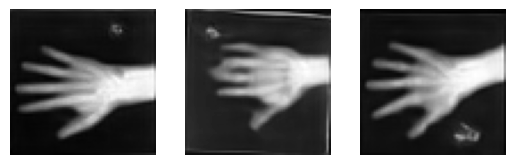

In [15]:
# Plot 3 examples from the synthetic data
fig, ax = plt.subplots(nrows=1, ncols=3)
for image_n in range(3):
    ax[image_n].imshow(syn_image[image_n, 0, :, :].cpu(), cmap="gray")
    ax[image_n].axis("off")

In [25]:
synch_eval_feats = torch.cat(synth_eval_feats, axis=0)
print(synch_eval_feats.shape, real_eval_feats.shape)

torch.Size([1005, 2048]) torch.Size([1005, 2048])


In [35]:
fid = FID()
results = fid(real_eval_feats.to(device), synch_eval_feats)
results.item()

nan

In [34]:
# Even when passing the same image, it returns NaNs
fid = FID()
results = fid(synch_eval_feats, synch_eval_feats)
results.item()

nan

In [36]:
# Even when passing the same image, it returns NaNs
fid = FID()
results = fid(real_eval_feats.to(device), real_eval_feats.to(device))
results.item()

nan

# Compute MMD

In [ ]:
# Generate a few samples (the 45 for the last batch)

n_synthetic_images = len(real_img)
syn_image = torch.randn((n_synthetic_images, 1, 64, 64))
syn_image = syn_image.to(device)
scheduler.set_timesteps(num_inference_steps=1000)

with torch.no_grad():

    z_mu, z_sigma = autoencoderkl.encode(syn_image)
    z = autoencoderkl.sampling(z_mu, z_sigma)

    noise = torch.randn_like(z).to(device)
    syn_image, intermediates = inferer.sample(
        input_noise=z, diffusion_model=unet, scheduler=scheduler, save_intermediates=True, intermediate_steps=100
    )
    syn_image = autoencoderkl.decode(syn_image)

In [ ]:
mmd = MMD()
mmd(real_img, syn_image)

In [ ]:
real_img.shape

In [ ]:
syn_image.cpu().shape

# Compute SSIM

In [ ]:
data_range = 1.0
mssim = MSSSIM(data_range=data_range)
mssim(real_img, syn_image)

In [ ]:
real_img.max()

In [ ]:
image1 = torch.ones([3, 3, 144, 144]) / 2
image2 = torch.ones([3, 3, 144, 144]) / 2

In [ ]:
data_range = 1.0
mssim = MSSSIM(data_range=data_range)
mssim(image1, image2)

In [27]:
from generative.metrics import  MSSSIM
import torch

data_range = torch.ones(1, 3)
image1 = torch.ones([3, 3, 144, 144]) / 2
image2 = torch.ones([3, 3, 144, 144]) / 2

mssim = MSSSIM(data_range=data_range)
mssim(image1, image2)

RuntimeError: The size of tensor a (138) must match the size of tensor b (3) at non-singleton dimension 5